Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [206]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [207]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [208]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [209]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [210]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
#print(df_perms.values)
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

In [211]:
from sklearn.feature_extraction.text import TfidfTransformer
trans_X = TfidfTransformer().fit_transform(X)
########################################################################
######################### Write your code here #########################
########################################################################

In [212]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
topics = 10
lda = LatentDirichletAllocation(n_components=topics, max_iter=10,n_jobs=-1)
lda.fit(trans_X)
########################################################################
######################### Write your code here #########################
########################################################################

CPU times: user 4.97 s, sys: 128 ms, total: 5.1 s
Wall time: 25.3 s


LatentDirichletAllocation(n_jobs=-1)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

In [213]:
n_words = 10
words = df_perms.columns
#print(words)
#print(lda.components_)
#c=0
for j,i in enumerate(lda.components_):
    #print(i.argsort()[:-1])
    o="Topic:%d"% (j+1)
    o+="\n"
    o+="\n ".join([words[j] for j in i.argsort()[:-n_words-1:-1]])
    o+="\n"
    print(o)
     
########################################################################
######################### Write your code here #########################
########################################################################

Topic:1
System tools : retrieve running applications (D)
 System tools : modify global system settings (D)
 Storage : modify/delete USB storage contents modify/delete SD card contents (D)
 Phone calls : read phone state and identity (D)
 System tools : mount and unmount filesystems (D)
 Network communication : view network state (S)
 Network communication : full Internet access (D)
 System tools : change your UI settings (D)
 System tools : set wallpaper (S)
 System tools : prevent device from sleeping (D)

Topic:2
Phone calls : read phone state and identity (D)
 Network communication : view Wi-Fi state (S)
 Network communication : view network state (S)
 Network communication : full Internet access (D)
 Storage : modify/delete USB storage contents modify/delete SD card contents (D)
 System tools : change Wi-Fi state (D)
 System tools : prevent device from sleeping (D)
 System tools : change network connectivity (D)
 System tools : allow Wi-Fi Multicast reception (D)
 Your personal inf

*** As observed from the results in the above code block, there are not clear differentiated purposes that we can identify as meaningful as the topics are an ensemble of many purposes.***

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [214]:
y=lda.transform(trans_X)
#print(t)
for i in range(10):
    idx = np.argsort(y[:,i])
    #print(idx)
    df["l"] =idx 
    dfst = df.sort_values(by=["l"], ascending=False)[["App", "Number of ratings"]] #Creating a new dataframes with Apps and Number of ratings as the two columns
    #print(dfst)
    app_names = dfst[dfst["Number of ratings"]>100000].head(n=3)["App"]
   # print(app_names)
    print("topic:" + str(i+1)+"\n")
    for app in app_names:
        print(app)
    print("\n")
########################################################################
######################### Write your code here #########################
########################################################################

topic:1

ES File Explorer
Yahoo! Mail
WeatherBug


topic:2

Toss It
Words With Friends Free
Slice It!


topic:3

Shazam
Lookout Security & Antivirus
Antivirus Free


topic:4

Racing Moto
LauncherPro
Tank Hero


topic:5

WeatherBug
Horoscope
Paradise Island


topic:6

Evernote
SpeechSynthesis Data Installer
Brightest Flashlight Free???


topic:7

Vaulty Free Hides Pictures
chompSMS
The Weather Channel


topic:8

ASTRO File Manager
Talking Tom Cat Free
Toss It


topic:9

The Weather Channel
LauncherPro
Adobe Flash Player 11


topic:10

Blast Monkeys
Angry Birds Rio
Tango Voice & Video Calls




Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.  
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.001s...
[t-SNE] Computed neighbors for 2500 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.015915
[t-SNE] KL divergence after 1000 iterations: -0.487804


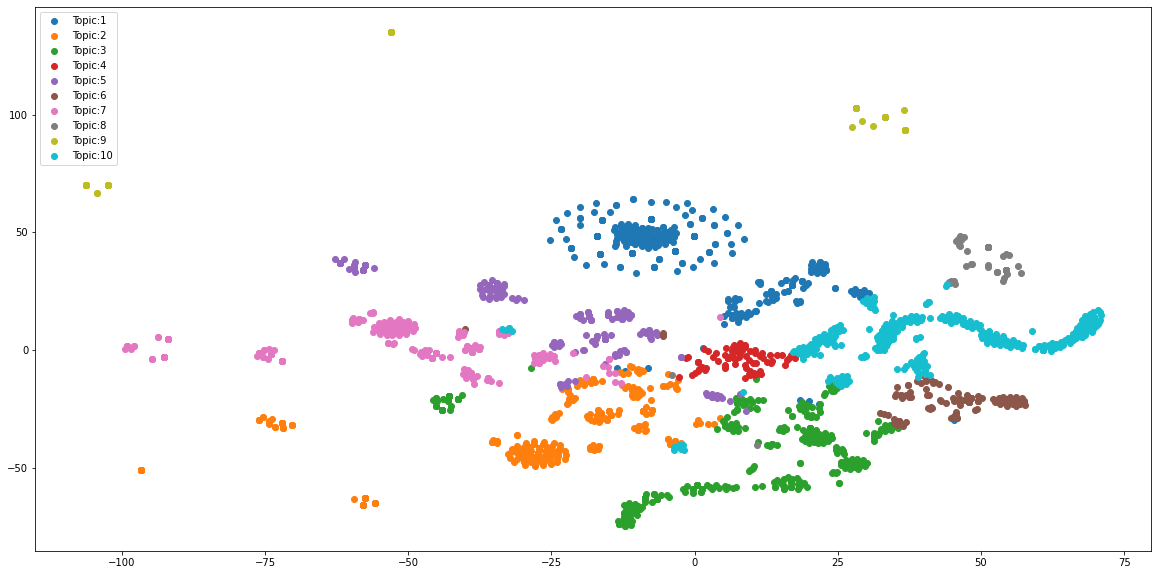

CPU times: user 42.2 s, sys: 5.5 s, total: 47.7 s
Wall time: 7.63 s


In [220]:
%%time
t=lda.transform(trans_X)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate=500,verbose=1, random_state=0, angle=.99, init='pca')

tsne_lda = tsne.fit_transform(t[:2500,:])
mpa = np.argmax(t, axis=1)[:2500]
#print(mpa)
#Plotting tSNE
plt.figure(figsize=(20,10))
for i in range(10):
    plt.plot(tsne_lda[mpa==i,0],tsne_lda[mpa==i,1], 'o',label="Topic:" + str(i+1))
plt.legend(loc='upper left')
plt.show()
########################################################################
######################### Write your code here #########################
########################################################################